# Кейс №1 - Приложение знакомств

Вы работаете аналитиком в приложении для онлайн-знакомств. Механика приложения следующая: пользователи видят в приложении анкеты друг друга и могут ставить друг другу лайки или дизлайки. Если пользователи поставили друг другу лайк – это называется мэтч, и у пользователей появляется возможность познакомиться.

Команда приложения разработала новый алгоритм для поиска наиболее подходящих анкет. Для проверки работы алгоритма был проведен АБ-тест. Все пользователи были разделены на две группы. Пользователи в группе с номером 0 пользовались приложением со старым алгоритмом. Все пользователи в группе 1 пользовались приложением с новым алгоритмом для поиска анкет.

Ваша задача – оценить, правда ли, что новый алгоритм улучшил качество сервиса. Для этого нужно выбрать метрики, которые отвечают за качество сервиса, и статистически сравнить эти метрики в двух группах.

В данных находится выгрузка логов взаимодействия пользователей друг с другом. Для каждой пары пользователей указано, из какой они группы АБ-теста и случился ли у них мэтч.

_______________________________________________________________________________________________________________________________

Для начала подгрузим необходимые библиотеки

In [1]:
import pandas as pd
import numpy as np
import pingouin as pg
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import requests
from urllib.parse import urlencode 
import scipy.stats as st


In [4]:
#Считаем файл и опишем данные
#user_id_1 - первый пользователь
#user_id_2 - второй пользователь
#group - группа, в которой находятся пользователи(0 - контрольная, 1 - тестовая)
#is_match - наличие метча между пользователями

base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key_dating_data = 'https://disk.yandex.ru/d/txn7q-CE2zSaPg' # ссылка на файл dating_data.csv

# Получаем загрузочные ссылки
final_url_dating_data = base_url + urlencode(dict(public_key=public_key_dating_data))
response_dating_data = requests.get(final_url_dating_data)
download_url_dating_data = response_dating_data.json()['href']

In [5]:
df = pd.read_csv(download_url_dating_data)
df.head()

,user_id_1,user_id_2,group,is_match
0,79,91,1,1
1,716,353,1,1
2,423,677,0,0
3,658,165,1,1
4,969,155,0,1


In [6]:
df.groupby('group').size() # определяем сколько наблюдений в каждой из групп

group
0    4792
1    9722
dtype: int64

In [7]:
df.groupby('group').user_id_1.nunique() # определяем количество пользователей в каждой группе

group
0    501
1    499
Name: user_id_1, dtype: int64

In [8]:
df.groupby('group').user_id_2.nunique() # для 2ой группы пользователей проделыываем предыдущее действие

group
0    501
1    499
Name: user_id_2, dtype: int64

Проверим, нет ли пересечения между группами пользователей с помощью множеств

In [9]:
gr_01 = set(df.query('group == 0').user_id_1)
gr_11 = set(df.query('group == 1').user_id_1)

gr_01.intersection(gr_11) # т.к. получаем пустое множество, то пересечения между группами пользователей нет

set()

In [10]:
gr_02 = set(df.query('group == 0').user_id_2)
gr_12 = set(df.query('group == 1').user_id_2)

gr_02.intersection(gr_12) # проделываем аналогичную операцию, что и с прошлыми группами, получаем также 
# пустое множество - пересечения между группами пользователей нет 

set()

$1.$$Проверим$ $произошло$ $ли$ $изменение$ $соотношения$ $метчей$ $и$ $не$-$метчей$
Есть две категориальные переменные → нужен хи-квадрат

- $H_0$: взаимосвязи между переменными нет 
- $H_1$: взаимосвязь есть

In [11]:
pd.crosstab(df.group, df.is_match) # отобразим кросстабуляцию, по ней можем понять разделение на группы(контрольной и тестовой),
# также видно количество мэтчей и не-мэтчей в каждой из групп

is_match,0,1
group,,
0,3858,934
1,5813,3909


In [11]:
# Т.к. у нас переменные категориальные, то проведем тест хи-квадрат

In [12]:
exp, obs, stats = pg.chi2_independence(data=df, x='group', y='is_match')

In [13]:
stats # выводим результаты теста

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,618.688914,1.0,1.441830e-136,0.206463,1.0
1,cressie-read,0.666667,628.560791,1.0,1.027630e-138,0.208104,1.0
2,log-likelihood,0.000000,652.966812,1.0,5.056969e-144,0.212106,1.0
3,freeman-tukey,-0.500000,675.931262,1.0,5.125545e-149,0.215803,1.0
4,mod-log-likelihood,-1.000000,703.556093,1.0,5.039774e-155,0.220169,1.0
5,neyman,-2.000000,775.869247,1.0,9.519662e-171,0.231207,1.0


In [14]:
# Возьмем p-value из 1-ой строки(Пирсона)
alpha = 0.05
if stats.pval[0] < alpha:
    print('Отклоняем 𝐻0')
else:
    print('Оставляем 𝐻0')
# Т.к. p-value сильно меньше альфы, то отклоняем нулевую гипотезу и принимаем альтернативную, 
# а значит взаимосвязь между переменными есть

Отклоняем 𝐻0


$2.$$Проверим$ $произошло$ $ли$ $изменение$ $числа$ $анкет$ $на$ $каждого$ $пользователя$


In [15]:
noq_user = df.groupby(['group', 'user_id_1'], as_index=False).size() # посчитаем количество мэтчей для каждого пользователя
noq_user

,group,user_id_1,size
0,0,4,9
1,0,10,6
2,0,12,12
3,0,14,8
4,0,15,20
...,...,...,...
995,1,987,23
996,1,992,21
997,1,993,18
998,1,998,18


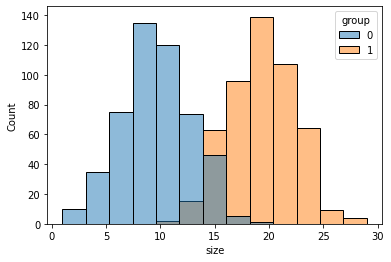

In [17]:
sns.histplot(data=noq_user, x='size', hue='group') # визуализируем данные и видим , что в тестовой группе анкет на пользователя
# оказалось больше

In [16]:
# Проверим статистически различия через t-test
pg.ttest(x=noq_user.query('group == 0')['size'], y=noq_user.query('group == 1')['size'])
# Т.к. p-value < 0.05, отвергаем нулевую гипотезу, различия есть

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-51.85607,997.694538,two-sided,2.005369e-285,"[-10.29, -9.54]",3.279531,9.827e+280,1.0


In [17]:
# Проведем также тест Манна-Уитни
pg.mwu(x=noq_user.query('group == 0')['size'], y=noq_user.query('group == 1')['size'])
# P-value < 0.05, статистически значимые различия есть, исходя из CLES понимаем, что в тестовой группе чаще встречаются
# высокие значения, чем в в контрольной

,U-val,alternative,p-val,RBC,CLES
MWU,3316.0,two-sided,6.905155e-157,0.973472,0.013264


### Вывод: исходя из данных тестов, наблюдаем, что между группами имеются статистически значимые различия, а значит необходимо включить новую систему поиска анкет на всех пользователей.